# Calories Burnt Prediction Project

This notebook demonstrates a complete workflow for predicting calories burnt during exercise using biometric and activity features. We use the Kaggle "Calories Burnt Prediction" dataset, which includes two files: `exercise.csv` (features) and `calories.csv` (target variable). The workflow covers data loading, cleaning, exploration, modeling, and evaluation.

## Step 1: Import Libraries

We import essential libraries for data manipulation (`numpy`, `pandas`), visualization (`matplotlib`, `seaborn`), and machine learning (`scikit-learn`, `xgboost`). These libraries are standard in data science and provide robust support for analysis and modeling.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import pickle

## Step 2: Load Datasets

We load the calories and exercise datasets. The calories dataset contains the target variable, while the exercise dataset contains the features. Loading both is necessary to prepare the data for supervised learning.


In [2]:
calories = pd.read_csv('calories.csv')
calories.head()

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0


In [3]:
exercise = pd.read_csv('exercise.csv')
exercise.head()


,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


## Step 3: Merge Datasets

We merge the exercise features and calories burnt into a single DataFrame. This step ensures that each record contains both input features and the corresponding target value, which is required for model training and evaluation.

In [4]:
calories_data = pd.concat([exercise, calories["Calories"]], axis = 1)
calories_data.head()


,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


## Step 4: Initial Data Exploration

We use `.describe()` to get summary statistics and `.info()` to check data types and missing values. This helps us understand the data distribution, spot anomalies, and plan preprocessing steps.

In [5]:
calories_data.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [6]:
calories_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


## Step 5: Missing Value Analysis

We check for missing values in each column. Identifying missing data is crucial before modeling, as it can affect model performance and may require imputation or removal.

In [7]:
calories_data.isnull().sum()

User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

## Step 6: Exploratory Data Analysis (EDA)

We visualize the distribution of categorical and numerical features. For example, we plot the gender distribution and histograms for age, height, weight, duration, heart rate, and body temperature. EDA helps us detect outliers, understand feature relationships, and guide feature engineering.

<Axes: xlabel='count', ylabel='Gender'>

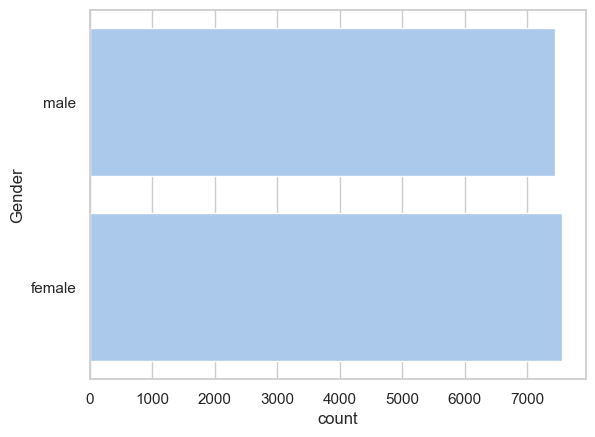

In [8]:
sns.set_style("whitegrid")
sns.set_context("notebook")
sns.set_palette("pastel")
sns.countplot(calories_data['Gender'])


### Gender Distribution Analysis

We visualize the distribution of gender in the dataset. This helps us understand if the data is balanced between male and female participants, which can impact model generalization and fairness.
We notice that the gender variable is equally distributed between 'male' and 'female'

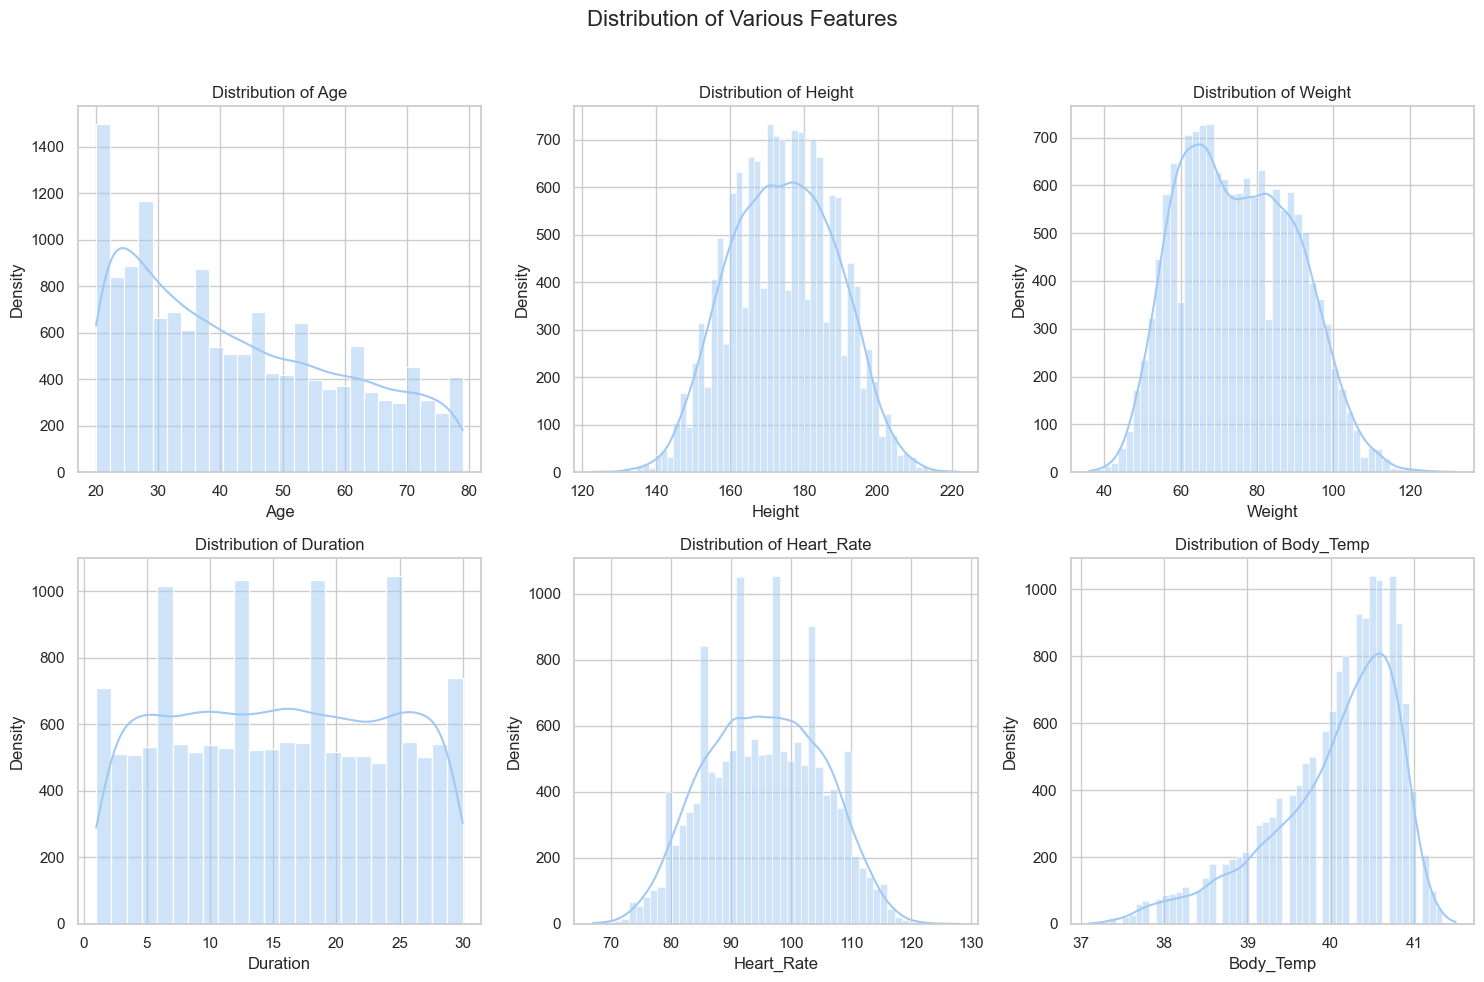

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Distribution of Various Features", fontsize=16)
variables = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
for var, ax in zip(variables, axes.flatten()):
    sns.histplot(calories_data[var], kde=True, ax=ax)  
    ax.set_title(f"Distribution of {var}")
    ax.set_xlabel(var)
    ax.set_ylabel("Density")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Analysis of Feature Distributions
We plot the distributions of key features (Age, Height, Weight, Duration, Heart Rate, Body Temperature). This helps us understand the spread and central tendency of each variable, identify skewness, and spot potential outliers.
- **Age:** The distribution is right-skewed, with more participants in younger age groups. This could influence model predictions, as the dataset is not age-balanced.
- **Height:** The distribution is approximately normal, suggesting no major bias in height among participants.
- **Weight:** The distribution is slightly right-skewed, with most participants having weights between 60 and 90 kg. Extreme weights are less common.
- **Duration:** The distribution is relatively uniform, indicating a good spread of exercise durations in the dataset.
- **Heart Rate:** The distribution is close to normal, centered around 100 bpm, which is typical for exercise sessions.
- **Body Temperature:** The distribution is right-skewed, with most values between 39°C and 41°C, consistent with elevated body temperature during physical activity.

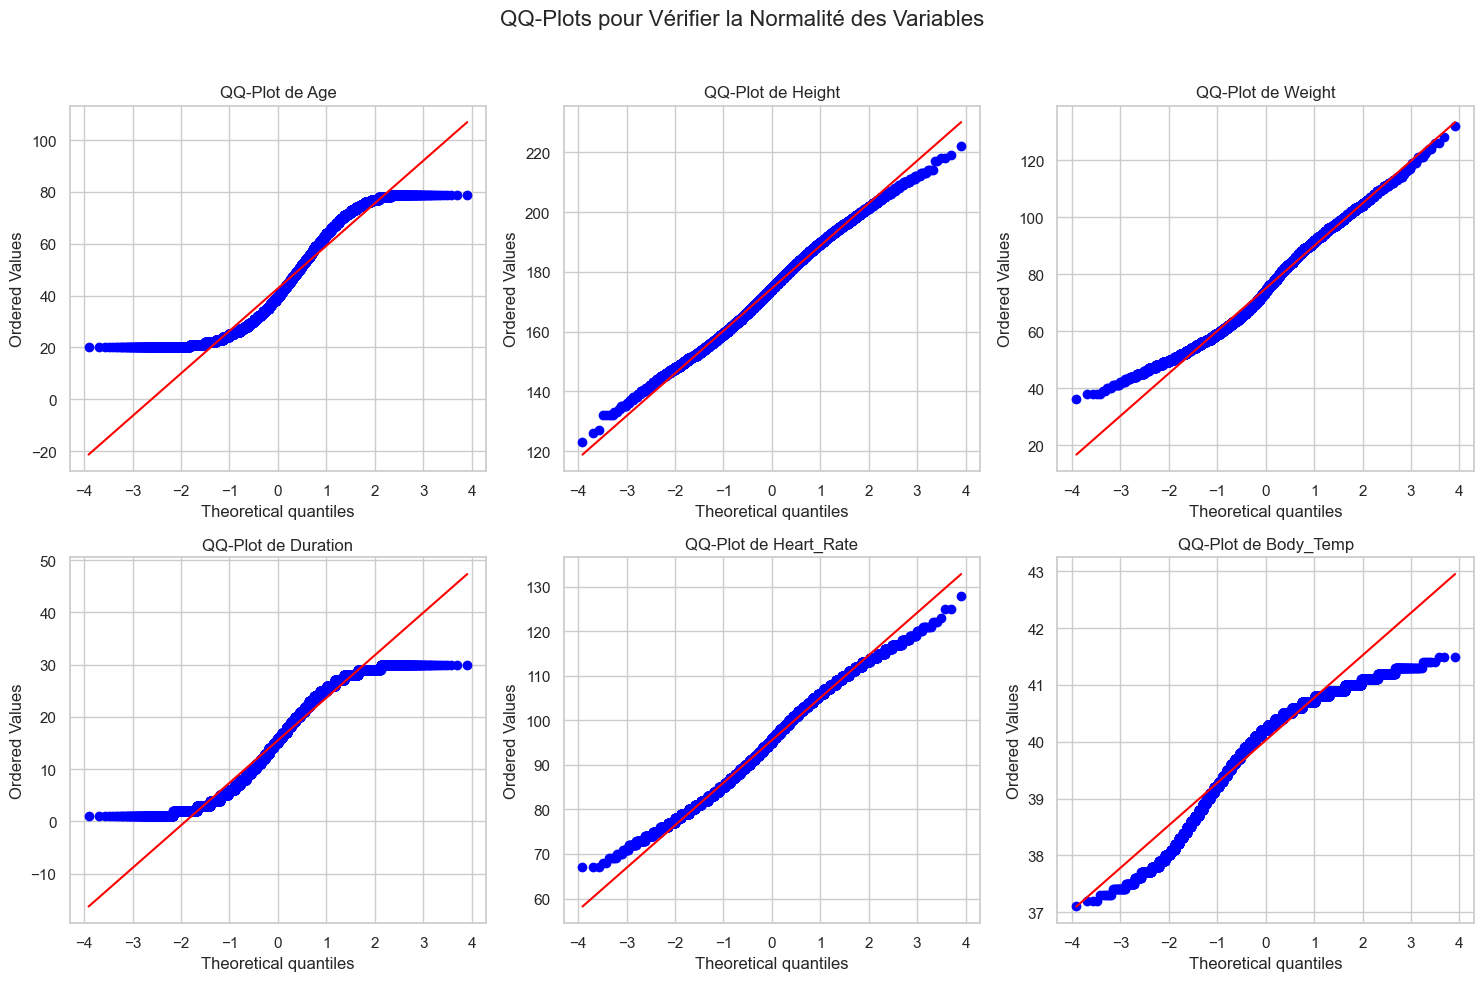

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("QQ-Plots pour Vérifier la Normalité des Variables", fontsize=16)

for var, ax in zip(variables, axes.flatten()):
    
    stats.probplot(calories_data[var], dist="norm", plot=ax)
    ax.set_title(f"QQ-Plot de {var}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Normality Assessment with QQ-Plots

QQ-plots are used to visually assess whether the feature distributions follow a normal distribution. This is important for certain statistical tests and can influence the choice of machine learning models and preprocessing techniques.


- **Age:** The QQ-plot for age shows noticeable deviation from the straight line, especially at the tails, indicating a non-normal distribution. This is consistent with the right-skewed histogram observed earlier.
- **Height:** The points closely follow the line, suggesting that height is approximately normally distributed in the dataset.
- **Weight:** The QQ-plot for weight shows mild deviation at the tails, but overall, the distribution is close to normal with some skewness.
- **Duration:** The QQ-plot for duration reveals clear deviations from normality, with heavy tails and a more uniform distribution, as seen in the histogram.
- **Heart Rate:** The heart rate QQ-plot is fairly linear, indicating a distribution close to normal, which matches the histogram.
- **Body Temperature:** The QQ-plot for body temperature shows deviation from normality, especially at the lower end, confirming the right-skewed nature seen in the histogram.

**Conclusion:** Most features are not perfectly normal, with age, duration, and body temperature showing the most deviation. This suggests that models which do not assume normality (e.g., tree-based models) may be more appropriate, and some features may benefit from transformation if normality is required.

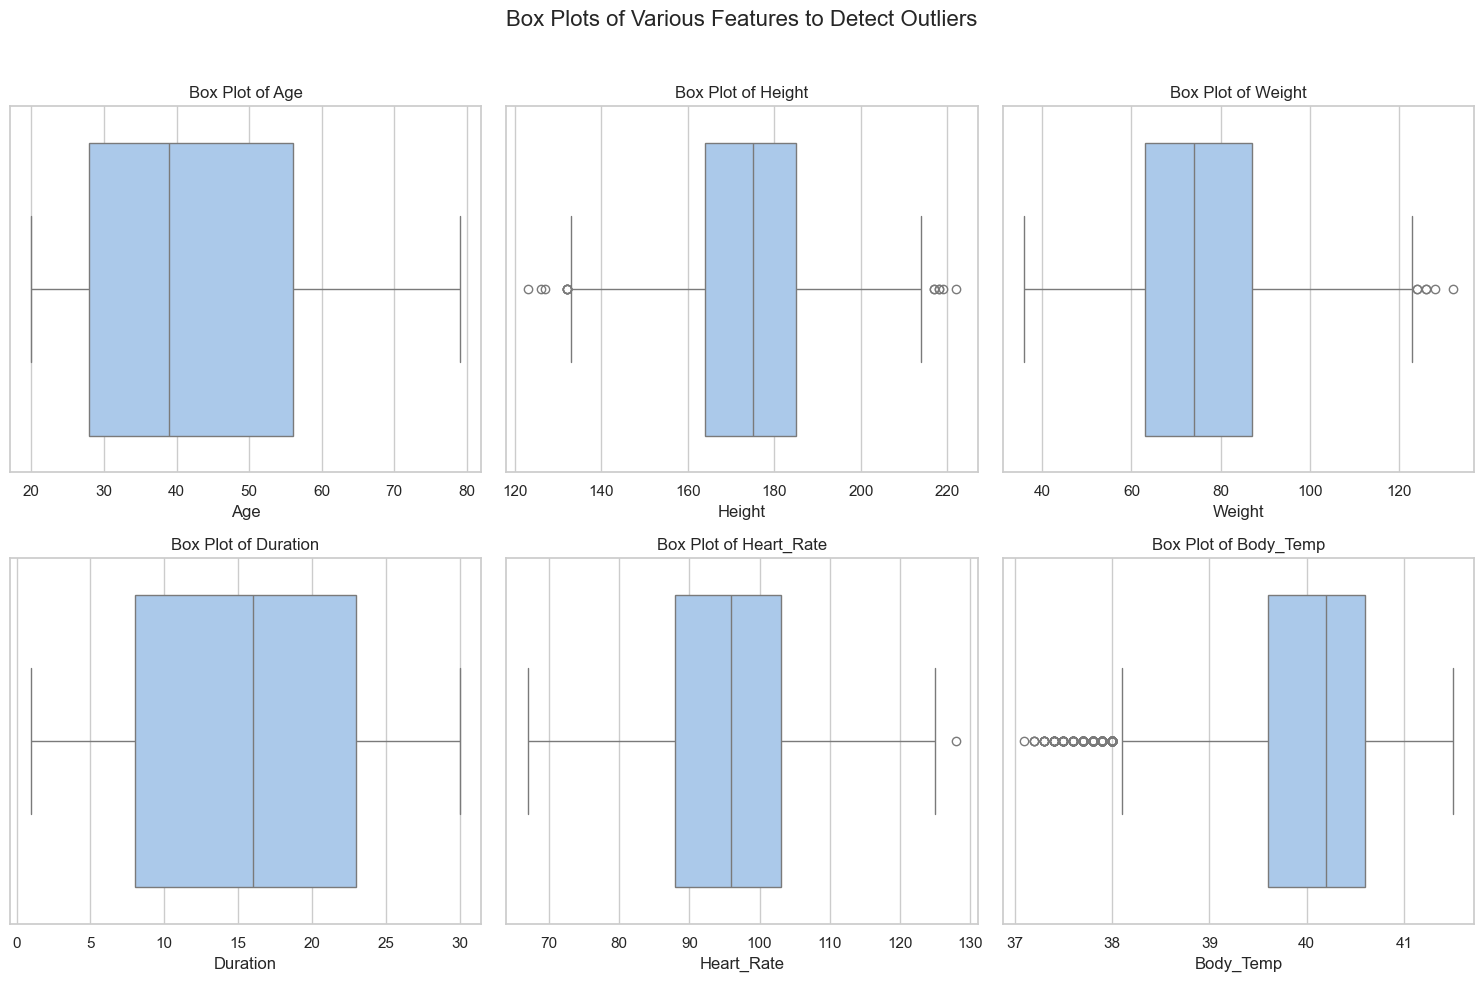

In [11]:

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Box Plots of Various Features to Detect Outliers", fontsize=16)
for var, ax in zip(variables, axes.flatten()):
    sns.boxplot(data=calories_data, x=var, ax=ax)
    ax.set_title(f"Box Plot of {var}")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Outlier Detection with Box Plots

Box plots help us identify outliers in each feature. Outliers can affect model performance and may need to be addressed through preprocessing or robust modeling techniques.
- **Age:** The box plot for age shows a symmetric distribution with no significant outliers, indicating a well-represented age range in the dataset.
- **Height:** There are a few outliers at both ends, but most data points are concentrated around the median. This suggests some extreme values but overall a normal spread.
- **Weight:** Several outliers are present at the higher end, which may represent individuals with unusually high weights. These should be considered during preprocessing, as they can affect model performance.
- **Duration:** The distribution is symmetric with no major outliers, indicating consistent exercise durations among participants.
- **Heart Rate:** There is a single outlier at the higher end, but most values are within a reasonable range for exercise sessions.
- **Body Temperature:** Multiple outliers are present at the lower end, possibly due to measurement errors or unique physiological responses.

<Axes: >

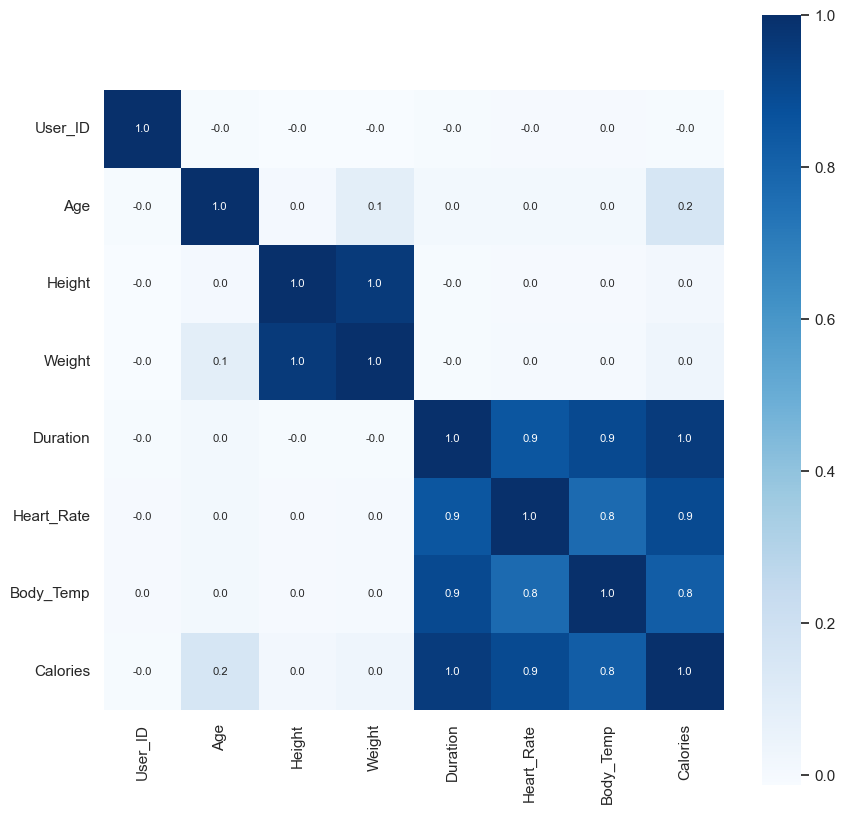

In [12]:
correlation_matrix = calories_data.drop(columns=['Gender']).corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

In [13]:
calories_data.replace({"Gender":{'male':0,'female':1}}, inplace= True)

C:\Users\Ben Youssef\AppData\Local\Temp\ipykernel_39844\693951255.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  calories_data.replace({"Gender":{'male':0,'female':1}}, inplace= True)


### Encoding Categorical Variables

We convert the 'Gender' column from categorical to numerical values. Most machine learning models require numerical input, so encoding is a necessary preprocessing step.

In [14]:
calories_data.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,0,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,1,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,0,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,1,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,1,27,154.0,58.0,10.0,81.0,39.8,35.0


### Feature and Target Selection

We separate the input features (X) from the target variable (Y) and we ommit the user_ID column. This is a standard step before training machine learning models.

In [15]:
X = calories_data.drop(columns= ['User_ID', 'Calories'], axis = 1)
Y = calories_data['Calories'] 

### Train-Test Split

We split the data into training and testing sets. The training set is used to fit the models, while the testing set is used to evaluate their performance on unseen data. This helps assess generalization and avoid overfitting.

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
print(X.shape, X_train.shape, X_test.shape)

(15000, 7) (12000, 7) (3000, 7)


In [17]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Support Vector Regressor": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}


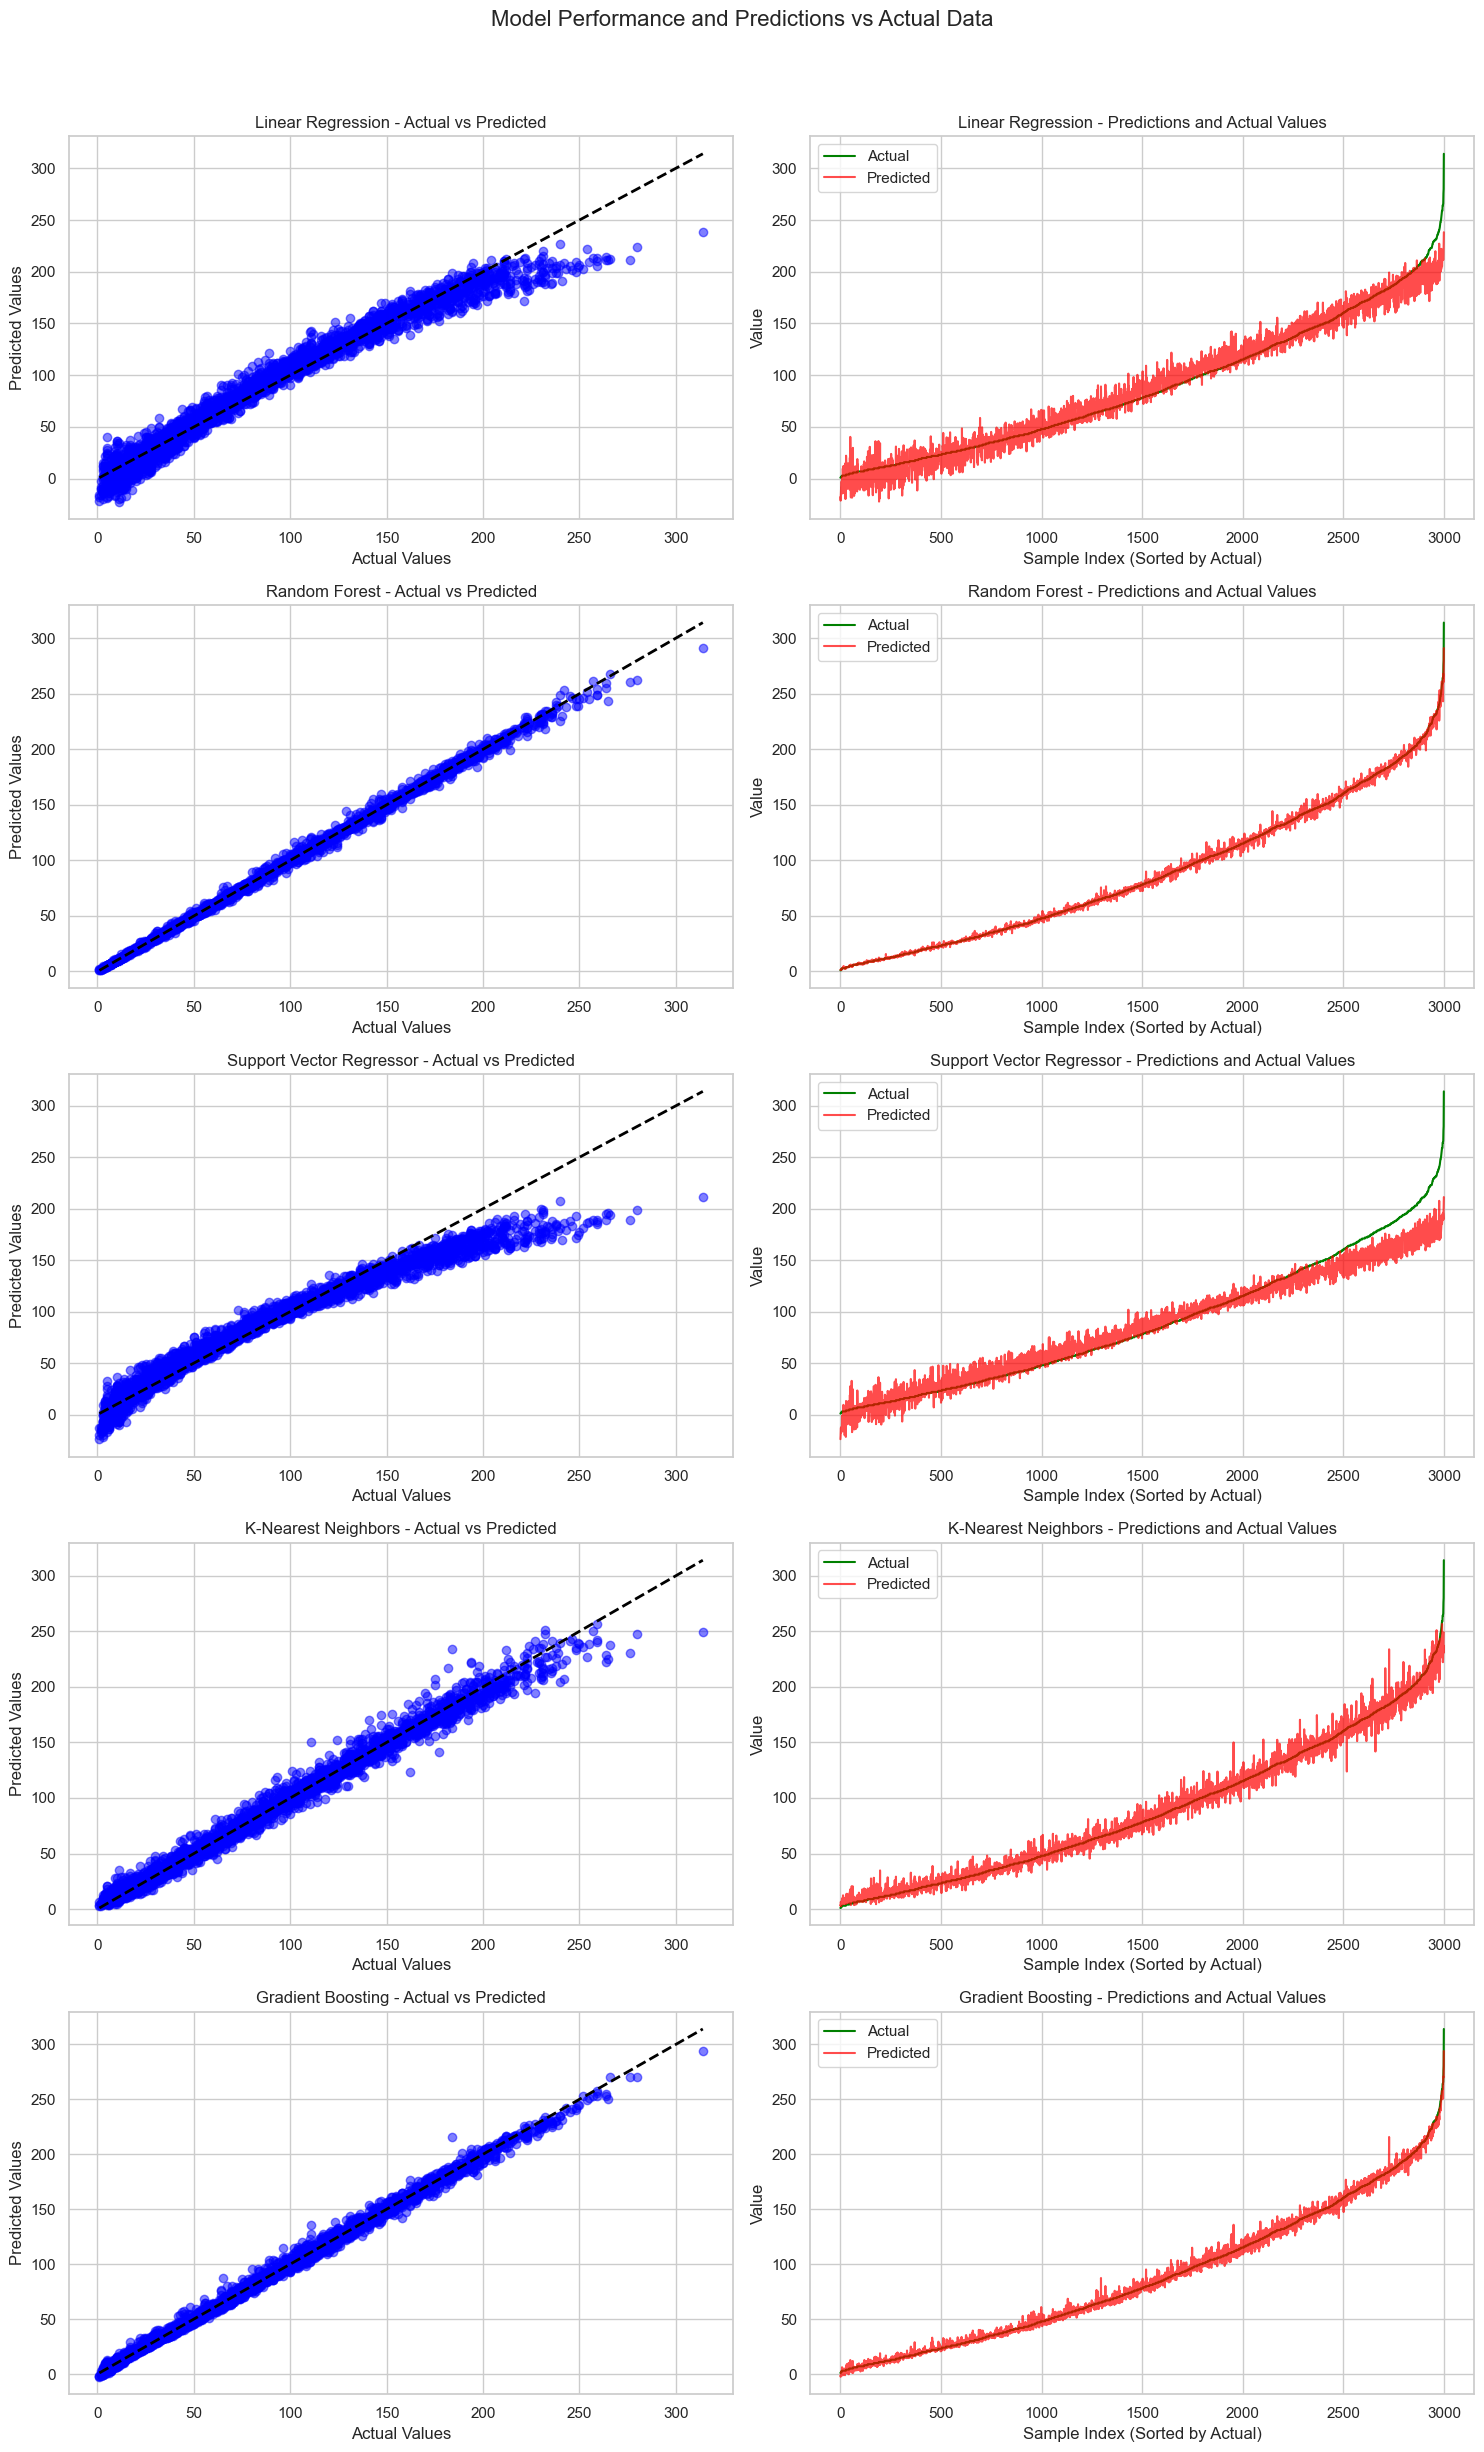

In [18]:
results = []
best_model = None
best_score = float('inf') 
fig, axes = plt.subplots(len(models), 2, figsize=(15, 5*len(models)))
fig.suptitle("Model Performance and Predictions vs Actual Data", fontsize=16)
for idx, (name, model) in enumerate(models.items()):
   
    model.fit(X_train, Y_train)
    test_data_prediction = model.predict(X_test)
    mae = mean_absolute_error(Y_test, test_data_prediction)
    mse = mean_squared_error(Y_test, test_data_prediction)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test, test_data_prediction)
    mae_scorer = make_scorer(mean_absolute_error)
    cv_scores = cross_val_score(model, X_train, Y_train, cv=5, scoring=mae_scorer)
    mean_cv_mae = cv_scores.mean()
    std_cv_mae = cv_scores.std()
    results.append({
        "Model": name,
        "Test MAE": mae,
        "Test MSE": mse,
        "Test RMSE": rmse,
        "Test R²": r2,
        "CV Mean MAE": mean_cv_mae,
        "CV Std MAE": std_cv_mae
    })
    if mean_cv_mae < best_score:
        best_score = mean_cv_mae
        best_model = model

    axes[idx, 0].scatter(Y_test, test_data_prediction, alpha=0.5, color="blue")
    axes[idx, 0].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)  
    axes[idx, 0].set_title(f"{name} - Actual vs Predicted")
    axes[idx, 0].set_xlabel("Actual Values")
    axes[idx, 0].set_ylabel("Predicted Values")

    sorted_indices = np.argsort(Y_test)  
    axes[idx, 1].plot(np.arange(len(Y_test)), np.array(Y_test)[sorted_indices], label="Actual", color="green")
    axes[idx, 1].plot(np.arange(len(Y_test)), np.array(test_data_prediction)[sorted_indices], label="Predicted", color="red", alpha=0.7)
    axes[idx, 1].set_title(f"{name} - Predictions and Actual Values")
    axes[idx, 1].set_xlabel("Sample Index (Sorted by Actual)")
    axes[idx, 1].set_ylabel("Value")
    axes[idx, 1].legend()


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


results_df = pd.DataFrame(results)

### Model Training, Evaluation, and Analysis


- We trained five regression models (Linear Regression, Random Forest, Support Vector Regressor, K-Nearest Neighbors, Gradient Boosting) to predict calories burnt.
- For each model, we:
  - Fit the model on the training data.
  - Predicted calories burnt on the test set.
  - Calculated performance metrics: MAE, MSE, RMSE, R².
  - Performed 5-fold cross-validation on the training set using MAE as the scoring metric.
  - Plotted Actual vs Predicted values and the sorted predictions against actuals for visual comparison.
  - Selected the best model based on the lowest mean cross-validation MAE.


- **Actual vs Predicted Scatter Plots:**
  - Points close to the diagonal line indicate good predictions. Gradient Boosting, KNN, and Random Forest show tight clustering along the line, suggesting strong performance. Linear Regression and SVR show more spread, indicating less accuracy.
- **Predictions vs Actuals Line Plots**:
  - The green line (actual) and red line (predicted) should overlap for a good model. Tree-based models (Random Forest, Gradient Boosting) and KNN have predictions closely following the actuals, while Linear Regression and SVR show larger deviations, especially at the extremes.
- **Model Comparison:**
  - Tree-based models and KNN outperform Linear Regression and SVR, both visually and likely in metrics. These models handle non-linear relationships and outliers better, which matches the earlier data analysis.
  - Gradient Boosting appears to be the best overall, with predictions most closely matching actual values.

In [19]:
print(results_df)

                      Model   Test MAE    Test MSE  Test RMSE   Test R²  \
0         Linear Regression   8.385188  130.087074  11.405572  0.966879   
1             Random Forest   1.679760    7.066454   2.658280  0.998201   
2  Support Vector Regressor  10.620614  243.293102  15.597856  0.938056   
3       K-Nearest Neighbors   5.052533   51.568213   7.181101  0.986870   
4         Gradient Boosting   2.778304   14.569056   3.816943  0.996291   

   CV Mean MAE  CV Std MAE  
0     8.336128    0.100616  
1     1.933010    0.067440  
2    11.697788    0.143065  
3     5.356533    0.065319  
4     2.719520    0.073324  


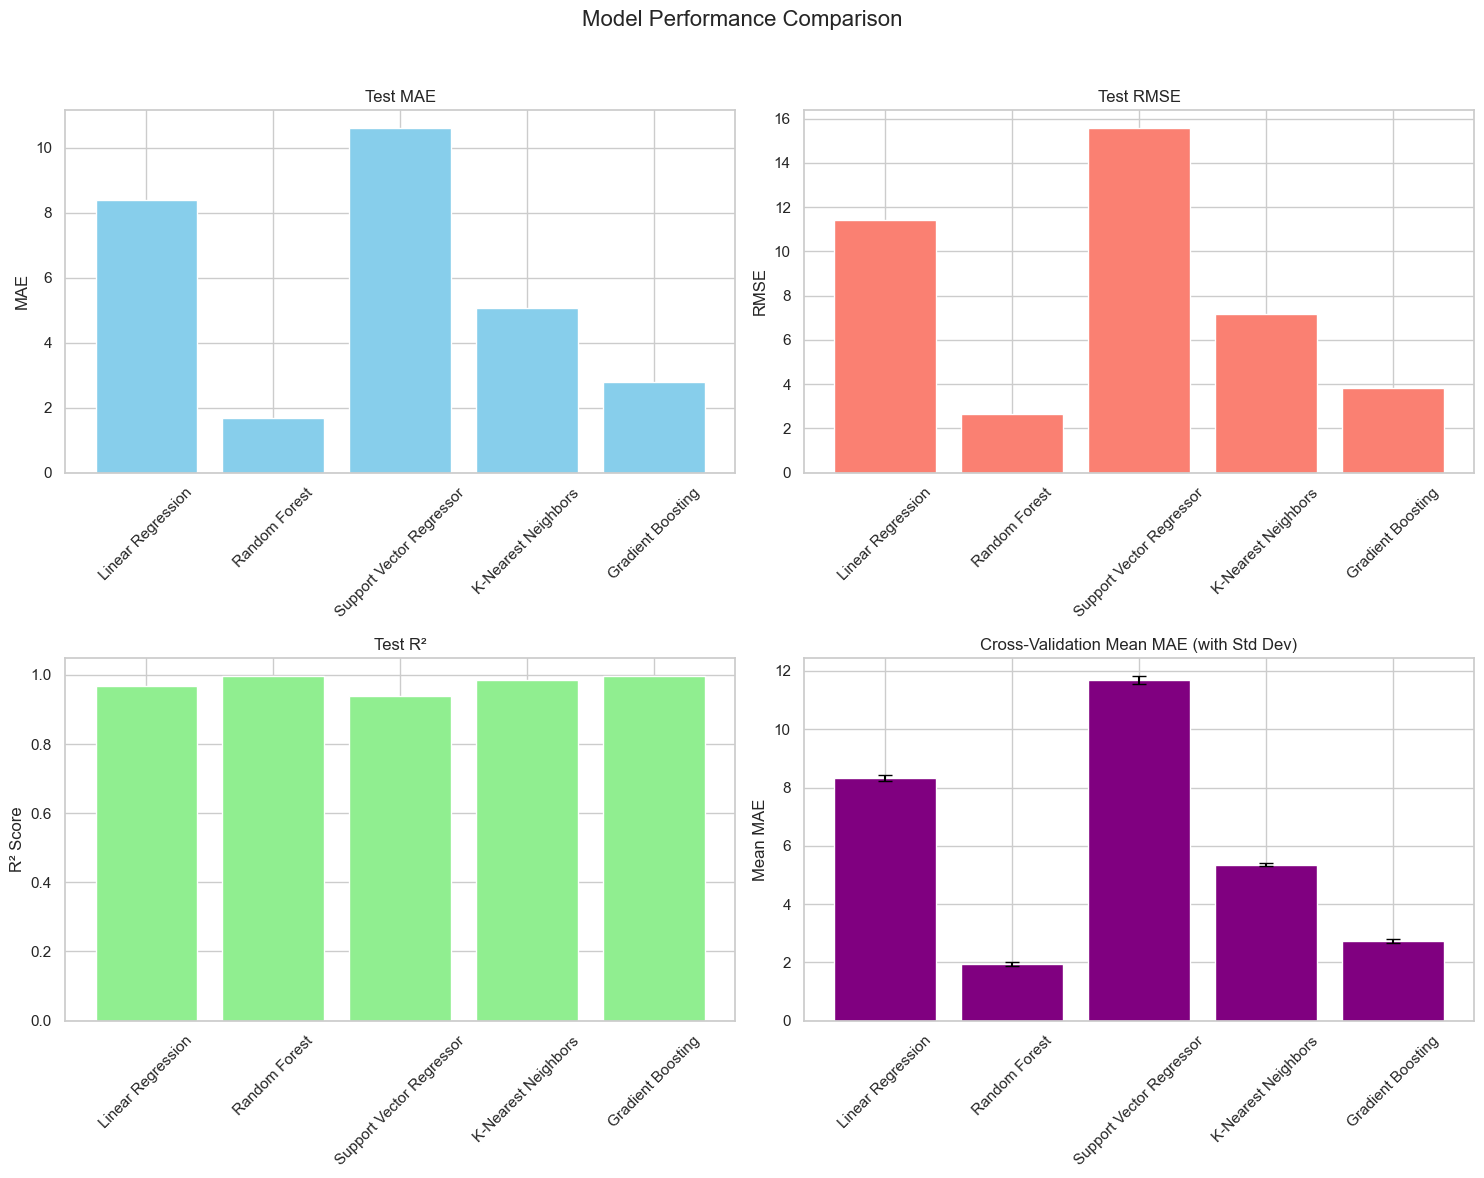

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Model Performance Comparison", fontsize=16)
axes[0, 0].bar(results_df["Model"], results_df["Test MAE"], color="skyblue")
axes[0, 0].set_title("Test MAE")
axes[0, 0].set_ylabel("MAE")
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].bar(results_df["Model"], results_df["Test RMSE"], color="salmon")
axes[0, 1].set_title("Test RMSE")
axes[0, 1].set_ylabel("RMSE")
axes[0, 1].tick_params(axis='x', rotation=45)


axes[1, 0].bar(results_df["Model"], results_df["Test R²"], color="lightgreen")
axes[1, 0].set_title("Test R²")
axes[1, 0].set_ylabel("R² Score")
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].bar(results_df["Model"], results_df["CV Mean MAE"], yerr=results_df["CV Std MAE"], capsize=5, color="purple")
axes[1, 1].set_title("Cross-Validation Mean MAE (with Std Dev)")
axes[1, 1].set_ylabel("Mean MAE")
axes[1, 1].tick_params(axis='x', rotation=45)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Model Performance Comparison and Analysis


- **Test MAE & RMSE:** Random Forest and Gradient Boosting have the lowest errors, indicating the most accurate predictions. Support Vector Regressor has the highest errors, showing poor fit for this dataset.
- **Test R²:** All models achieve high R² scores (>0.93), but Random Forest and Gradient Boosting are closest to 1, meaning they explain nearly all variance in the target variable.
- **Cross-Validation Mean MAE:** Random Forest and Gradient Boosting also perform best in cross-validation, with low mean MAE and small standard deviation, indicating consistent performance across folds. SVR has the highest error and variability.

#### Insights
- **Best Models:** Random Forest and Gradient Boosting are the top performers, both in test and cross-validation metrics. They are robust to outliers and non-normality, which matches the earlier data analysis.
- **K-Nearest Neighbors:** Performs well, but not as strong as the tree-based models.
- **Linear Regression:** Reasonable performance, but limited by the data's non-linear relationships and outliers.
- **Support Vector Regressor:** Underperforms, likely due to the complexity and distribution of the data.

**Conclusion:**
- Tree-based models (Random Forest, Gradient Boosting) are recommended for this regression task. They consistently outperform other models in both accuracy and reliability.
- The visual comparison confirms the quantitative results in `results_df`, supporting the choice of the best model for deployment or further tuning.

In [21]:
print(best_model)

RandomForestRegressor()


In [22]:
filename = 'trained_best_model.sav'
pickle.dump(best_model, open(filename,'wb'))

In [23]:
loaded_model = pickle.load(open('trained_best_model.sav','rb'))

### Model Explainability

Understanding why a model makes certain predictions is important, especially in health-related applications. Explainability helps build trust, identify biases, and guide feature engineering.

#### Approaches to Explainability
- **Feature Importance:** Tree-based models like Random Forest and Gradient Boosting provide feature importance scores, showing which variables most influence predictions. Visualizing these scores can highlight key drivers of calorie burn.
- **SHAP Values:** SHAP (SHapley Additive exPlanations) values offer a unified approach to interpret any model, showing the impact of each feature on individual predictions. SHAP plots can reveal global and local patterns, outliers, and interactions.
- **Partial Dependence Plots:** These plots show how the predicted outcome changes as a single feature varies, holding others constant. They help understand non-linear effects and feature interactions.



C:\Users\Ben Youssef\AppData\Local\Temp\ipykernel_39844\3285955044.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


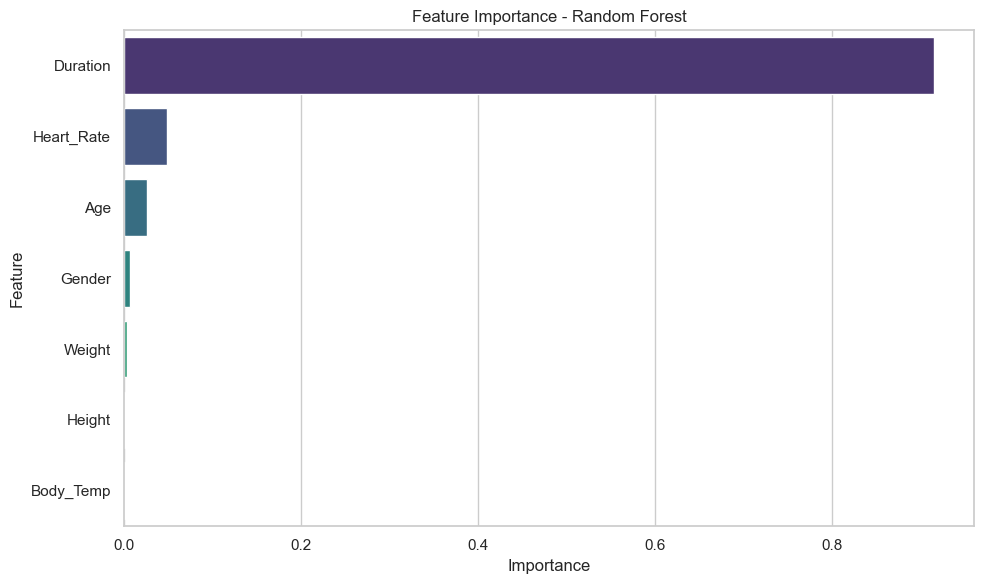

100%|===================| 2998/3000 [02:15<00:00]        

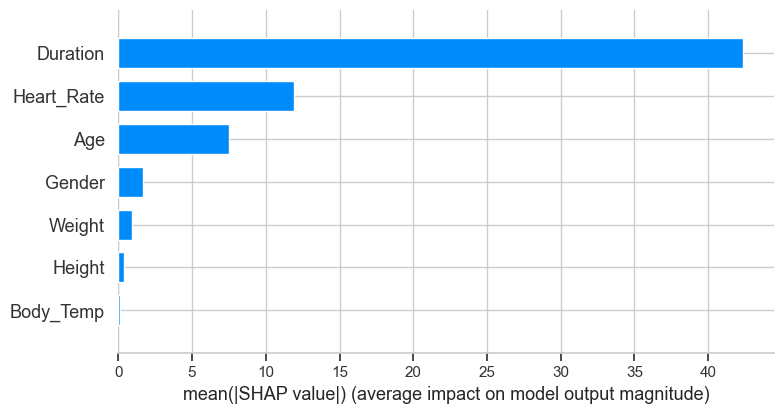

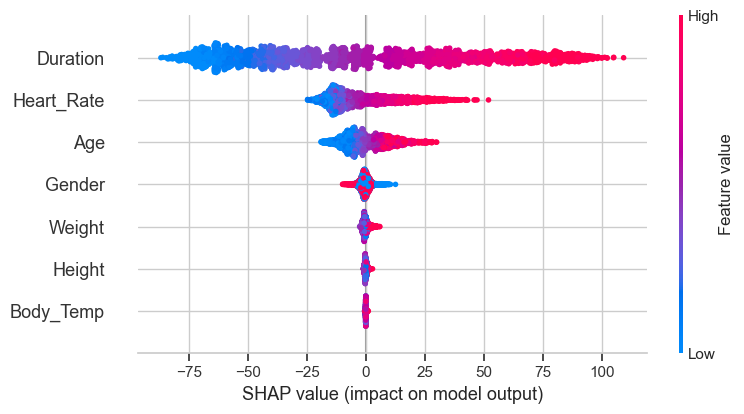

In [27]:

importances = best_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

import shap
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

# Summary plot for global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed summary plot for feature effects
shap.summary_plot(shap_values, X_test)

### Interpretation and Analysis of Explainability Plots

#### Feature Importance (Random Forest)
The bar plot shows that **Duration** is overwhelmingly the most important feature for predicting calories burnt, followed by **Heart Rate** and **Age**. Features like Gender, Weight, Height, and Body Temperature have minimal impact. This means that the length of the exercise session is the primary driver of calorie expenditure in this dataset.

#### SHAP Summary Bar Plot
The SHAP bar plot confirms the dominance of **Duration** as the most influential feature, with **Heart Rate** and **Age** also contributing. SHAP values quantify the average impact of each feature on the model's output, providing a more nuanced view than simple feature importance.

#### SHAP Beeswarm Plot
The beeswarm plot reveals how individual feature values affect predictions:
- High Duration and Heart Rate values (shown in pink) push predictions higher, while low values (blue) lower the predicted calories burnt.
- Age also has a positive effect, but less pronounced than Duration and Heart Rate.
- Other features have little impact, as seen by the tight clustering around zero.

**Summary:**
- Both methods agree on the most important features, but SHAP provides deeper insight into how feature values drive predictions for each sample.
- The results suggest that focusing on exercise duration and heart rate is key for accurate calorie prediction, while other features play a minor role in this dataset.